In [1]:
%pip install gym-trading-env

In [2]:
import gymnasium as gym
import gym_trading_env
import yfinance as yf
from pprint import pprint
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN,HER
import pandas as pd
from preprocessors import FeatureEngineer
from yahoodownloader import YahooDownloader
import numpy as np
from env2 import TradingEnv
%matplotlib inline

In [3]:
stock_name = "MSFT"
start_date_train = "2020-01-01"
end_date_train = "2023-01-01"
start_date_test = "2023-01-01"
end_date_test = "2023-04-01"

timesteps = 1e5

In [4]:
def get_data(stock_name, start_date, end_date):
    df = yf.download(stock_name, start=start_date, end=end_date)
    df = df.reset_index()
    df.columns = [x.lower() for x in df.columns]
    df = df.dropna()
    return df

In [5]:
DOW_30_TICKER = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW",
]

In [6]:
df_train = YahooDownloader(start_date=start_date_train,
                     end_date = end_date_train,
                     ticker_list = [stock_name]).fetch_data()
df_test = YahooDownloader(start_date=start_date_test,
                        end_date = end_date_test,
                        ticker_list = [stock_name]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (62, 8)


In [7]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30',
            'close_30_sma',
            'close_60_sma',
            'close_30_ema',
            'close_60_ema',
            'close_180_ema',
            'boll',
            'boll_ub',
            'boll_lb']


In [8]:
def add_indicators(df):
    fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)
    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    return processed

In [9]:
df_train = add_indicators(df_train)
df_test = add_indicators(df_test)


Successfully added technical indicators
Successfully added technical indicators


In [10]:
df_train.head()
# Set index col

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,close_30_ema,close_60_ema,close_180_ema,boll,boll_ub,boll_lb
0,2020-01-02,158.779999,160.729996,158.330002,154.779541,22622100,MSFT,3,0.000000,0.000000,-66.666667,100.000000,154.779541,154.779541,154.779541,154.779541,154.779541,154.779541,156.541497,151.090293
1,2020-01-03,158.320007,159.949997,158.059998,152.852249,21116200,MSFT,4,-0.043241,0.000000,-66.666667,100.000000,153.815895,153.815895,153.783774,153.799834,153.810541,153.815895,156.541497,151.090293
2,2020-01-06,157.080002,159.100006,156.509995,153.247330,20813700,MSFT,0,-0.042846,17.495923,-87.783388,100.000000,153.626373,153.626373,153.592910,153.609494,153.620714,153.626373,155.662418,151.590329
3,2020-01-07,159.320007,159.669998,157.320007,151.850052,21634100,MSFT,1,-0.092064,10.667505,-66.995469,50.876142,153.182293,153.182293,153.112689,153.147400,153.170644,153.182293,155.615186,150.749400
4,2020-01-08,158.929993,160.800003,157.949997,154.268829,27746500,MSFT,2,-0.020622,47.417678,68.754356,0.334641,153.399600,153.399600,153.375739,153.386883,153.395189,153.399600,155.719875,151.079325


In [11]:
num_actions = int(1e3 + 1)
positions = np.linspace(0, 1, num_actions).tolist()
# env_train = gym.make('TradingEnv', df=df_train, positions = positions,portfolio_initial_value = 100000)
# env_test = gym.make('TradingEnv', df=df_test, positions = positions,portfolio_initial_value = 100000)
# import env check
from stable_baselines3.common.env_checker import check_env
env_train = TradingEnv(df_train)
env_test = TradingEnv(df_test)
check_env(env_train, warn=False)
check_env(env_test, warn=False)

In [25]:
def simulate(env,models = None):
    observation, info = env.reset()
    truncated, done = False, False
    history = []
    while not done:
        action = None
        if models:
            action = 0
            if(type(models) != list):
                models = [models]
            for model in models:
                action += model.predict(observation, deterministic=True)[0]
            action /= len(models)
            action = int(action)
        else:
            action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        if truncated:
            break
        history.append(info)
    return history

In [21]:
def plot_history(history):
    # Convert dictionary to dataframe
    df = pd.DataFrame(history)
    actions = df['position']
    valuation = df['portfolio_value']
    dates = df['date']
    close = np.array(df['close'])
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(dates, close)
    ax1.scatter(dates, close, c=actions)
    ax1.set_xlabel('date')
    ax1.set_ylabel('valuation')
    fig.tight_layout()
    plt.show()
    valuation = np.array(valuation).reshape(-1)
    
    print("Total return: ", (valuation[-1] - valuation[0]) / valuation[0])
    print("Buy and hold return: ", (close[-1] - close[0]) / close[0])

[{'portfolio_value': array([100000.]), 'balance': array([8512.00170914]), 'position': array([31.]), 'current_step': 1, 'action': array([-0.0147412]), 'date': '2020-01-03', 'close': 152.8522491455078}, {'portfolio_value': array([100000.]), 'balance': array([8512.00170914]), 'position': array([31.]), 'current_step': 2, 'action': array([-0.33103484]), 'date': '2020-01-06', 'close': 153.24732971191406}, {'portfolio_value': array([99875.86966293]), 'balance': array([8512.00170914]), 'position': array([31.]), 'current_step': 3, 'action': array([0.40686347]), 'date': '2020-01-07', 'close': 151.8500518798828}, {'portfolio_value': array([99752.06065491]), 'balance': array([8512.00170914]), 'position': array([31.]), 'current_step': 4, 'action': array([-0.09306249]), 'date': '2020-01-08', 'close': 154.26882934570312}, {'portfolio_value': array([99642.5674765]), 'balance': array([8512.00170914]), 'position': array([31.]), 'current_step': 5, 'action': array([0.93760881]), 'date': '2020-01-09', 'clo

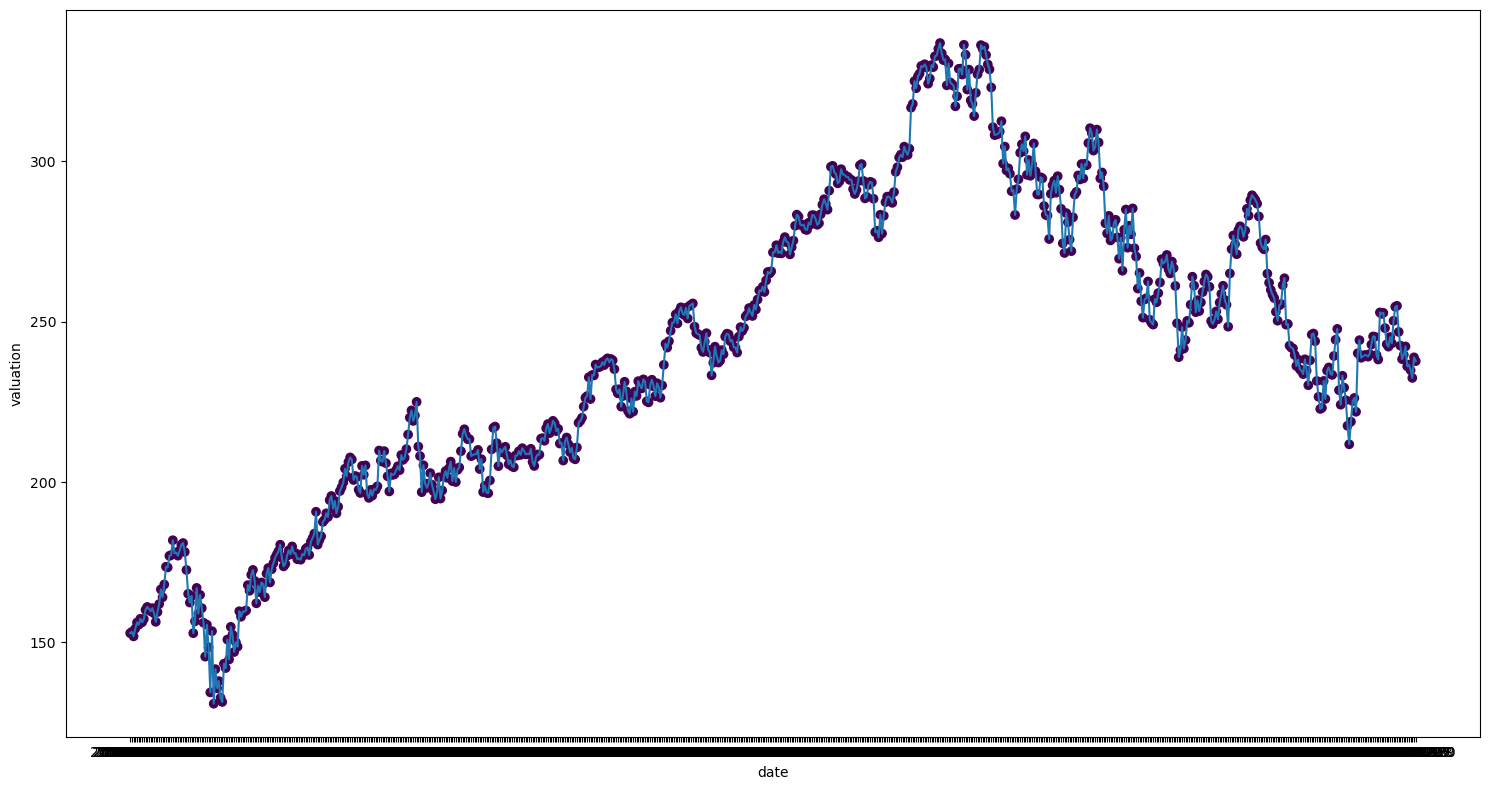

Total return:  [-0.84082353]
Buy and hold return:  0.555176656442713


In [26]:
history = simulate(env_train)
print(history[:10])
plot_history(history)

In [15]:
model = PPO('MultiInputPolicy', env_train, verbose=1, n_epochs=20)
model.learn(total_timesteps=timesteps)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 755       |
|    ep_rew_mean     | -2.82e+03 |
| time/              |           |
|    fps             | 311       |
|    iterations      | 1         |
|    time_elapsed    | 6         |
|    total_timesteps | 2048      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 755        |
|    ep_rew_mean          | -478       |
| time/                   |            |
|    fps                  | 267        |
|    iterations           | 2          |
|    time_elapsed         | 15         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00250455 |
|    clip_fraction        | 0.00784    |
|    clip_range           | 0.2        |
|    entropy_loss     

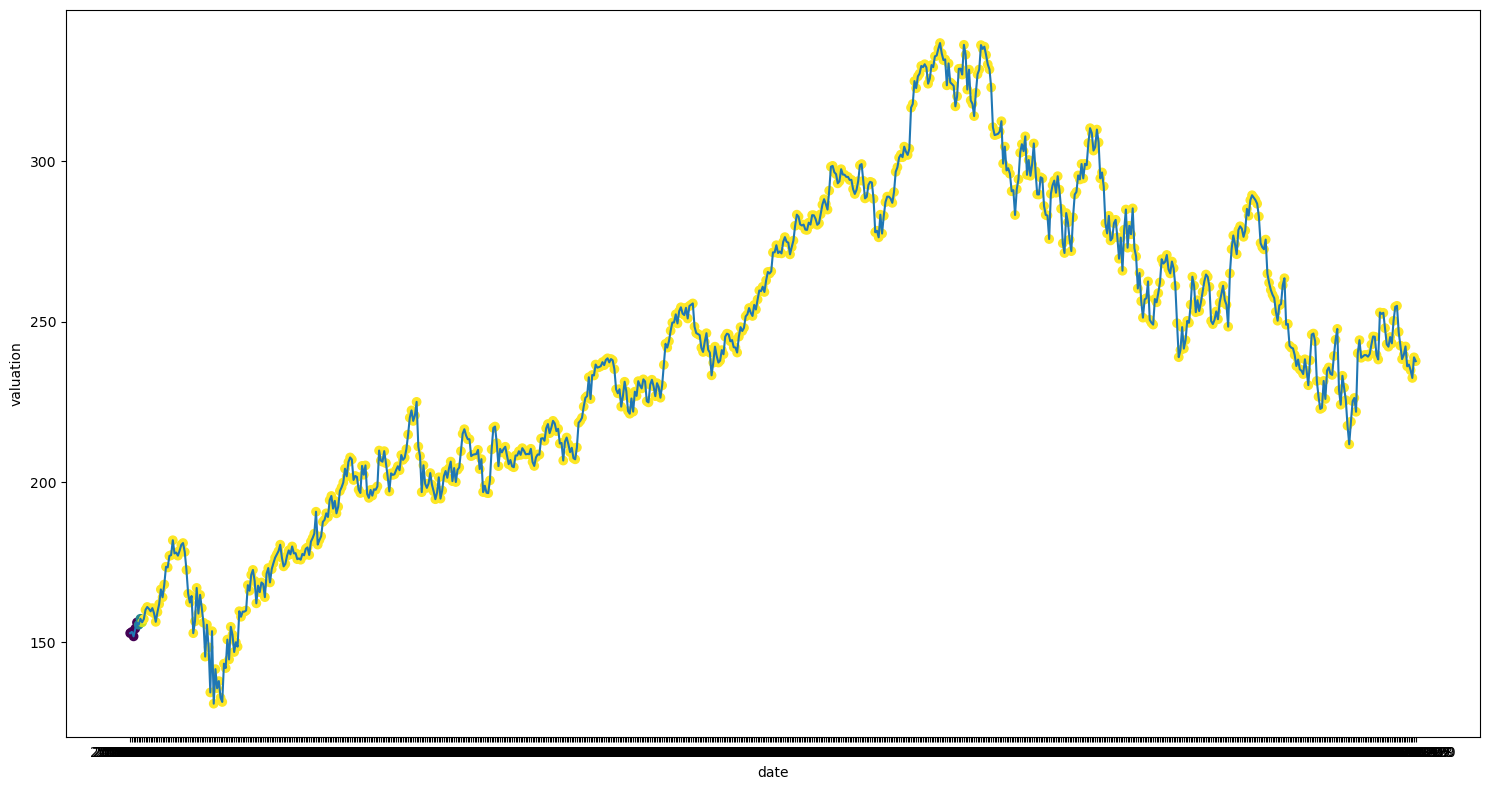

Total return:  0.5196237174371809
Buy and hold return:  0.555176656442713


In [24]:
history = simulate(env_train, model)
plot_history(history)

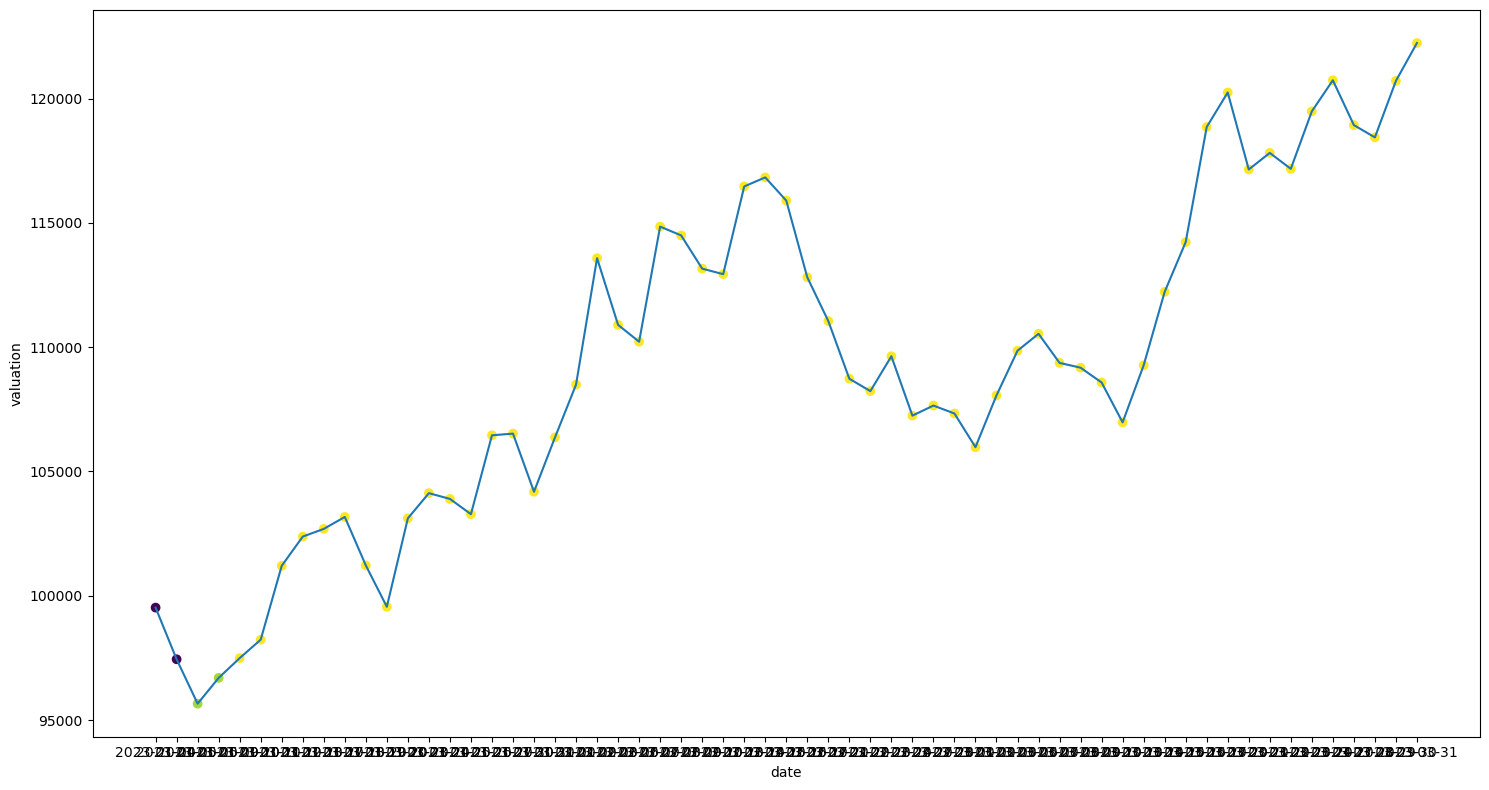

Total return:  0.22816196942334288
Buy and hold return:  0.2615541993469037


In [17]:
history = simulate(env_test, model)
plot_history(history)

In [18]:
a2c_model = A2C('MultiInputPolicy', env_train, verbose=1)
ppo_model = PPO('MultiInputPolicy', env_train, verbose=1)
dqn_model = DQN('MultiInputPolicy', env_train, verbose=1)

models = [a2c_model, ppo_model]
for model in models:
    model.learn(total_timesteps=timesteps)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Box(-1.0, 1.0, (1,), float64) was provided

Market Return : 53.58%   |   Portfolio Return : 41.54%   |   


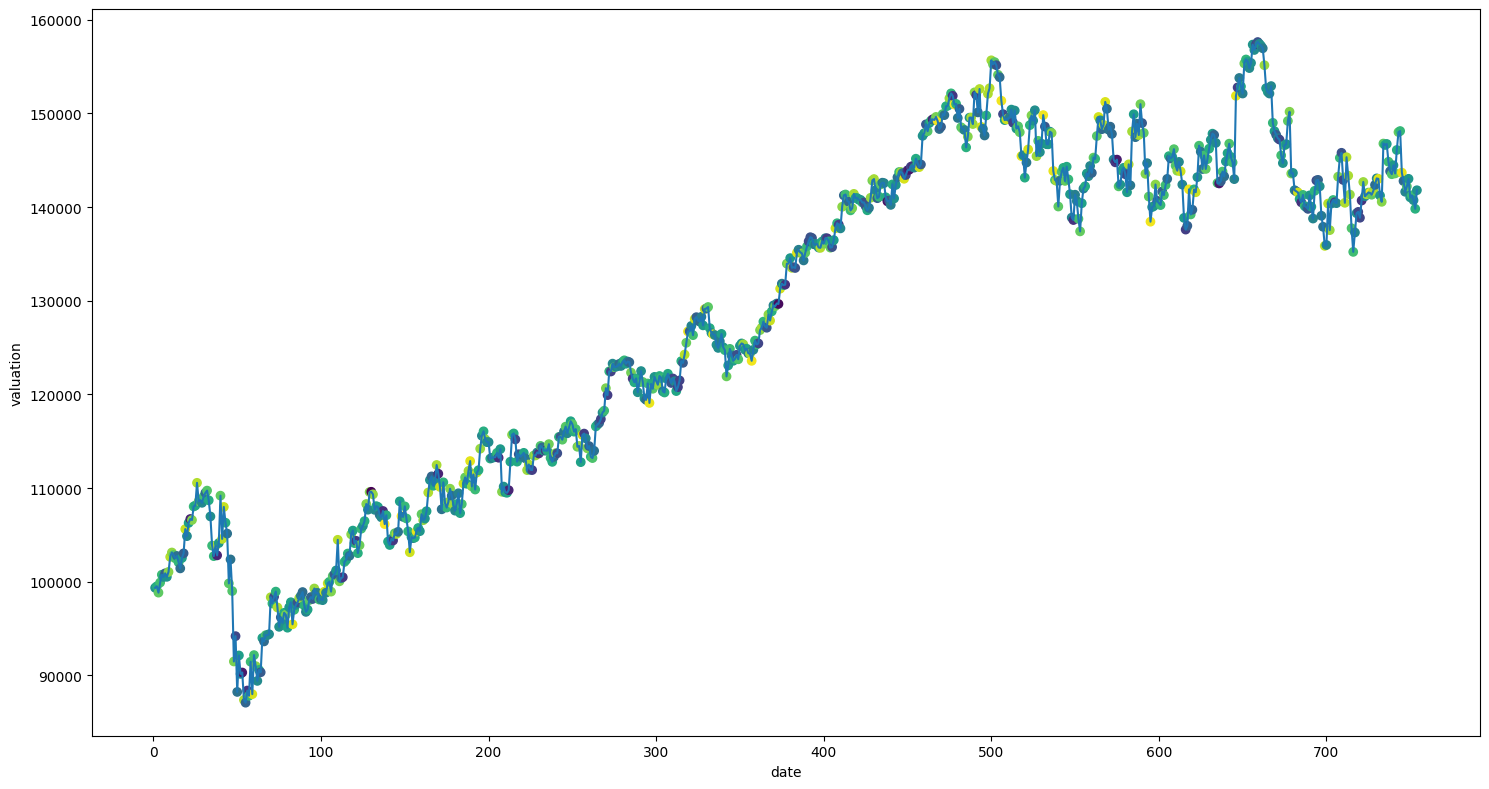

In [ ]:
history = simulate(env_train, models)
plot_history(history)

Market Return : 20.64%   |   Portfolio Return : 10.08%   |   


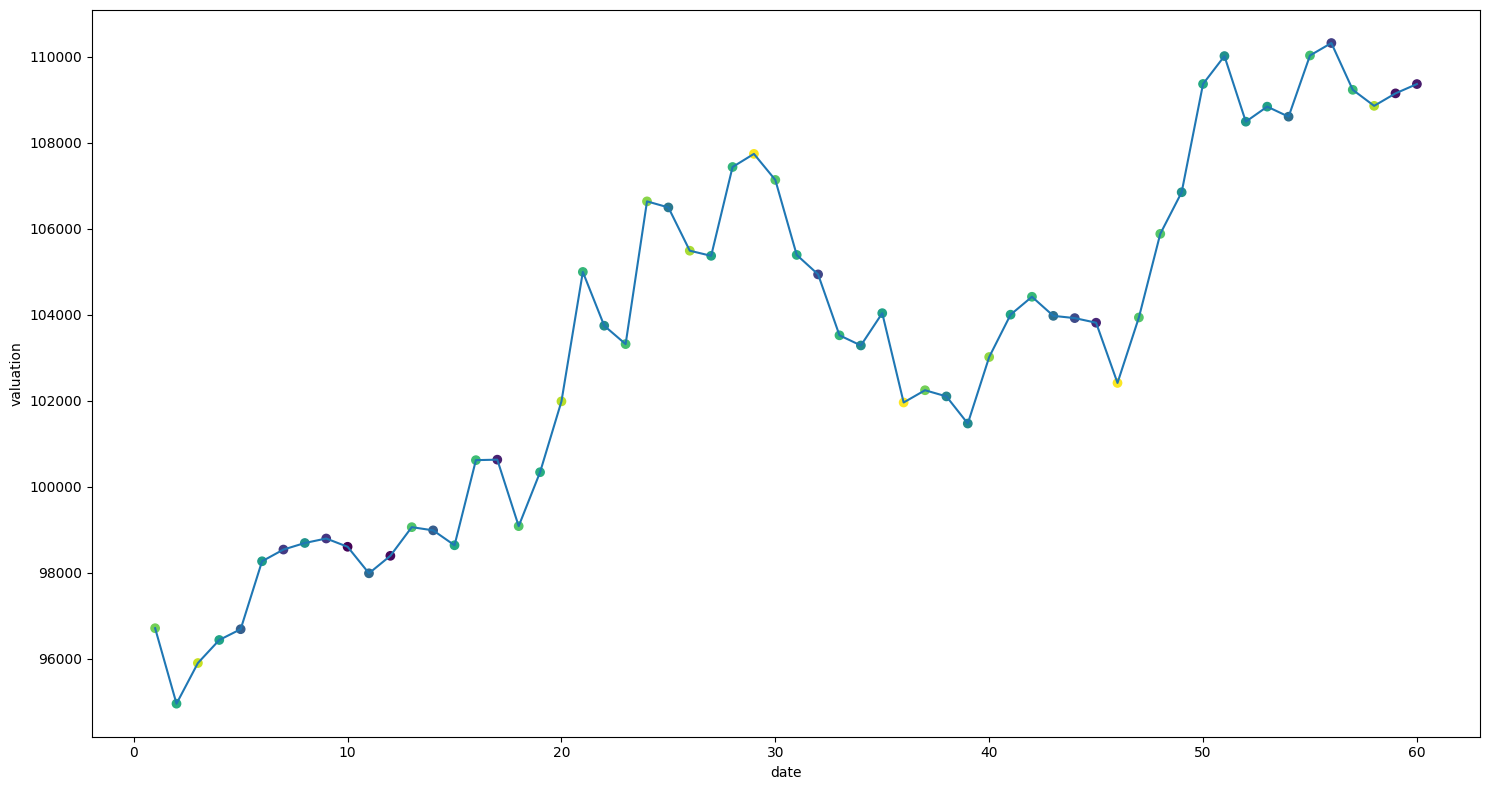

In [ ]:
history = simulate(env_test, models)
plot_history(history)